# 🦌 RuDOLPH 350M

<b><font color="white" size="+2">Official colab of [RuDOLPH: One Hyper-Modal Transformer can be creative as DALL-E and smart as CLIP](https://github.com/sberbank-ai/ru-dolph)</font></b>


<font color="white" size="-0.75."><b>RuDOLPH</b> is a fast and light text-image-text transformer (350M GPT-3) for generating text like <b>GPT</b>, generating image (e.g.: image by text, image by image prompt) like <b>DALL-E</b>, generating image captions, image classification in Zero-Shot mode and image ranking like <b>CLIP</b>. 

<b>RuDOLPH 350M</b> is designed for quick and easy fine-tuning setup for solution of various tasks: from generating images by text description and image classification, to visual question answering and more. This colab demonstates the power of Hyper-Modal Transfomers.</font>

Hyper-modality means generalized multi-modal, e.g., model that consists of two multi-modal parts: text-2-image and image-2-text becomes text and image hyper-modality model

<font color="white" size="-0.75."><b>RuDOLPH for fast zero-shot text to image generation.</b> On the first phase we generate 288 in 5 min images by text! It takes Diffusion decoder is based on [Jack000](https://github.com/Jack000/) solution and ESRGAN-Real for high quality image rendering.</font>

# install all

In [1]:
!pip install rudolph==0.0.1rc0 > /dev/null
!pip install bitsandbytes-cuda111
!pip install wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 4.0 MB 12.5 MB/s 
     |████████████████████████████████| 1.7 MB 5.8 MB/s 
     |████████████████████████████████| 180 kB 52.2 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 142 kB 52.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=2ee0e00aaf49ebc2b8dd63597e9b16f14fde741e5df995b5be29eeeec0567cd3
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for 

#Download data

In [2]:
!gdown https://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o
!unzip food.zip

Downloading...
From: https://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o
To: /content/food.zip
100% 34.8M/34.8M [00:00<00:00, 163MB/s]
Archive:  food.zip
   creating: food/
  inflating: food/.jpg               
  inflating: food/food.csv           
  inflating: food/Австралийский овощной хлеб.jpg  
  inflating: food/Ажурные блины.jpg  
  inflating: food/Английский куриный суп с сыром.jpg  
  inflating: food/Армянская ариса.jpg  
  inflating: food/Армянский лаваш.jpg  
  inflating: food/Бабушкин сладкий плов.jpg  
  inflating: food/Баклажанный крем-суп .jpg  
  inflating: food/Баклажаны, запеченные с сыром .jpg  
  inflating: food/Бархатная курица, приготовленная секретным способом.jpg  
  inflating: food/Бархатные блинчики.jpg  
  inflating: food/Бархатный грибной суп.jpg  
  inflating: food/Белорусский холодник.jpg  
  inflating: food/Беляши домашние.jpg  
  inflating: food/Бисквит .jpg  
  inflating: food/Бисквит и секрет его приготовления.jpg  
  inflating: food/Бисквит

#Explain data

In [3]:
import pandas as pd
df = pd.read_csv('/content/food/food.csv')


In [4]:
df.head()

,Unnamed: 0,"Белки, г:","Жиры, г:","Углеводы, г:","Калории, ккал:",name,path
0,0,6.4,3.3,48.9,256.5,Австралийский овощной хлеб,Австралийский овощной хлеб.jpg
1,1,5.6,3.8,29.3,172.8,Ажурные блины,Ажурные блины.jpg
2,2,6.8,5.9,46.7,264.2,Армянский лаваш,Армянский лаваш.jpg
3,3,4.8,5.4,19.1,144.1,Бархатные блинчики,Бархатные блинчики.jpg
4,4,1.5,10.4,4.1,156.2,Беляши домашние,Беляши домашние.jpg


# train this deer

In [1]:
import torch
from rudalle import get_tokenizer, get_vae
from rudalle.utils import seed_everything

import sys
from rudolph.model.utils import get_i2t_attention_mask, get_t2t_attention_mask
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph.pipelines import generate_codebooks, self_reranking_by_image, self_reranking_by_text, show, generate_captions, generate_texts, zs_clf
from rudolph import utils
device = 'cuda'

model = get_rudolph_model('350M',  fp16=True, device='cuda')
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [2]:
import os
class Args():
    def __init__(self,model):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 4
        self.save_path='checkpoints/'
        self.model_name = 'awesomemodel_'
        self.save_every = 500
        self.prefix_length = 10
        self.bs = 10
        self.clip = 1.0
        self.lr = 2e-5
        self.warmup_steps =50
        self.wandb = True
args = Args(model)
if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

In [3]:
#markdown Data preparation
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class RuDolph(Dataset):
    clip_filter_thr = 0.24
    def __init__(
            self,
            args,
            file_path,
            csv_path,
            tokenizer,
            resize_ratio=0.75,
            shuffle=True,
            load_first=None,
            caption_score_thr=0.6
    ):
        """ 
        tokenizer - объект с методами tokenizer_wrapper.BaseTokenizerWrapper
         """
       
        self.text_seq_length = model.get_param('l_text_seq_length')
        self.tokenizer = tokenizer
        self.target_image_size = 128
        self.image_size=128
        self.samples = []


        self.image_transform = T.Compose([
                T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
                T.RandomResizedCrop(self.image_size,
                                    scale=(1., 1.), # в train было scale=(0.75., 1.),
                                    ratio=(1., 1.)),
                T.ToTensor()
            ])
        
        df = pd.read_csv(csv_path)
        df.columns = ['index','belok','fats','uglevod','kkal','name','path']

        for belok, fats, uglevod, kkal, caption, f_path   in zip(df['belok'],df['fats'], df['uglevod'], df['kkal'] ,df['name'], df['path']):

            caption = f'белков:{belok}, жиров: {fats}, углеводов: {uglevod}, ккал: {kkal}, {caption}'
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):

              self.samples.append([file_path, f_path, caption.lower()])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')
    
    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        image = PIL.Image.open(f'{file_path}/{img_name}')
        return image

    def __getitem__(self, item):
        item = item % len(self.samples)  # infinite loop, modulo dataset size
        file_path, img_name, text = self.samples[item]
        
        try:
          image = self.load_image(file_path, img_name)
          image = self.image_transform(image).to(device)
        except Exception as err:  # noqa
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        text = text.lower().strip()
        encoded = tokenizer.encode_text(text, text_seq_length=args.r_text_seq_length).to(args.device)
       
        return encoded, image

#RuDolph Dataset class
##Simple dataset class where you pass .csv with 


filepath - name of dir where you store images

________________________

**name     |     caption**
________________________
*Image name* | *Caption*

In [4]:
from torch.utils.data import Dataset, DataLoader

dataset = RuDolph(args=args,file_path='/content/food' ,csv_path ='/content/food/food.csv',tokenizer=tokenizer)

train_dataloader = DataLoader(dataset, batch_size=args.bs, shuffle=True, drop_last=True)

Shuffled


In [5]:
#Setup logs
#import os
#os.environ["WANDB_START_METHOD"] = "thread"
try:
  import wandb
  wandb.init(project = args.model_name, entity = "alexwortega") #change it
  args.wandb = True
except:
  args.wandb = False

wandb: Currently logged in as: alexwortega (use `wandb login --relogin` to force relogin)


In [6]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [7]:
from transformers import  AdamW, get_linear_schedule_with_warmup
import bitsandbytes as bnb

model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, 
                                                final_div_factor=500,  
                                                steps_per_epoch=len(train_dataloader), epochs=args.epochs )




# Lets train for captioning task, test trained model [here](https://huggingface.co/spaces/AlexWortega/food_calories)

In [8]:
#markdown Simple training loop
device = model.get_param('device')

def train(model,args: Args, train_dataloader: RuDolph):
  """
  args - arguments for training

  train_dataloader - RuDalleDataset class with text - image pair in batch
  """


  loss_logs = []
  try:
    progress = tqdm(total=len(train_dataloader)*args.epochs, desc='finetuning goes brrr🦌🎄☃️')
    save_counter = 0

    for epoch in range(args.epochs):
      
      for text, images in train_dataloader:
        
        save_counter+=1
        model.zero_grad()

        masks = torch.ones(args.bs, args.r_text_seq_length, dtype=torch.int32)
        total_seq_length = args.l_text_seq_length + args.image_seq_length + args.r_text_seq_length

        attention_mask = torch.tril(torch.ones((args.bs, 1, total_seq_length, total_seq_length), device=device))
       
        image_input_ids = vae.get_codebook_indices(images)
        input_ids = torch.cat((text, image_input_ids, text), dim=1)


        loss, loss_values = model.forward(input_ids, attention_mask,  return_loss=True)
        


        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        #save every here
        if save_counter % args.save_every == 0:
          print(f'Saveing checkpoint here {args.model_name}_dalle_{save_counter}.pt')
          
          plt.plot(loss_logs)
          plt.show()
          torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}_dalle_{save_counter}.pt")
                    )
        if args.wandb:
          wandb.log({"loss":  loss.item()})
        
        loss_logs+=[loss.item()]
        progress.update()
        progress.set_postfix({"loss": loss.item()})
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}dalle_last.pt")
                )
  
  except KeyboardInterrupt:
    
    
    print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_dalle_Failed_train.pt')
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_Failed_train.pt")
                )
  except Exception as err:
    print(f'Failed with {err}')

finetuning goes brrr🦌🎄☃️:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim
finetuning goes brrr🦌🎄☃️: 100%|██████████| 196/196 [04:35<00:00,  1.40s/it, loss=5.26]

Complitly tuned and saved here  awesomemodel___dalle_last.pt


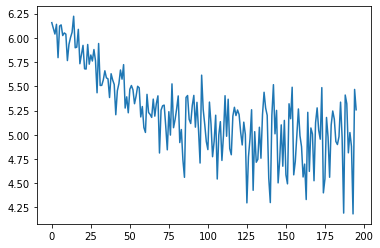

finetuning goes brrr🦌🎄☃️: 100%|██████████| 196/196 [04:37<00:00,  1.41s/it, loss=5.26]


In [9]:
model = freeze(model = model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False)#freeze params to 

train(model, args, train_dataloader)

#Lets test it

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim


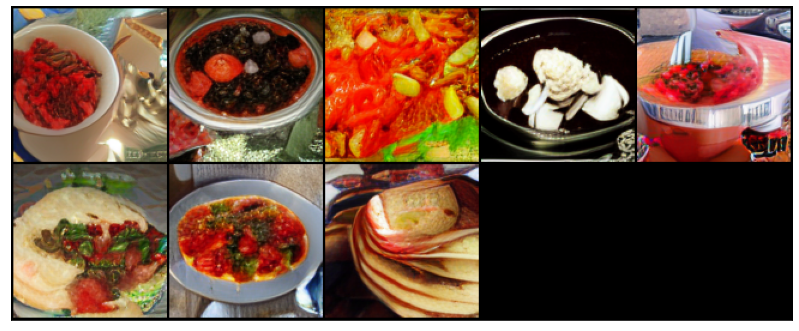

In [10]:
#@title 336 Text-2-Image Generations 

#@markdown <b><font color="white" size="+0.5">(~5 min ⌚) Type text or select use_generated_task</font></b>

text = 'белков:5.2, жиров: 5.2, углеводов: 29.0, ккал: 182.8, борщ' #@param {type:"string"}



images_num = 8#@param {type:"slider"}
bs = 48

seed_everything(42)
codebooks = []
for top_k, top_p, images_num in [
    (2048, 0.995, images_num),
    
]:
    codebooks.append(
        generate_codebooks(text, tokenizer, model, top_k=top_k, images_num=images_num, top_p=top_p, bs=bs, seed=0)
    )

codebooks = torch.cat(codebooks)

ppl_text, ppl_image = self_reranking_by_text(
    text,
    codebooks,
    tokenizer,
    model,
    bs=bs,
)
with torch.no_grad():
    images = vae.decode(codebooks[ppl_text.argsort()[:25]])

pil_images = utils.torch_tensors_to_pil_list(images)
show(pil_images, 5)